## Importing dataset and visualization

In [7]:
import PRF
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath('../'))
from utils import load_keel_dataset
from utils import add_noise, add_label_noise

file_path="../KEEL/keel_data/iris.dat"


X_train, X_test, y_train, y_test, label_map = load_keel_dataset(
        train_path=file_path,
        already_split=False
    )
    # Ensure labels are adjusted to start from 0
if (min(set(y_train))==1):
    y_train = y_train - 1  
    y_test = y_test - 1  

noise_scale = 0.9
label_noise_range = (0.0,0.5)
X_train_noisy, _, dX, _ = add_noise(X_train, noise_type="gaussian", noise_scale=noise_scale)
y_train_noisy, _, py, _ = add_label_noise(y_train, mode="random_prob", random_seed=29, prob_range=label_noise_range)
print("Head of training data: \n", X_train[:10])
print("Head of noisy training data: \n", X_train_noisy[:10])
print("Head of labels: \n", y_train[:20])
print("Head of noisy labels: \n", y_train_noisy[:20])

Head of training data: 
 [[1.602e+01 2.324e+01 1.027e+02 7.978e+02 8.200e-02 6.700e-02 3.300e-02
  3.300e-02 1.530e-01 5.700e-02 3.800e-01 1.187e+00 2.466e+00 4.051e+01
  4.000e-03 9.000e-03 1.100e-02 8.000e-03 1.500e-02 3.000e-03 1.919e+01
  3.388e+01 1.238e+02 1.150e+03 1.180e-01 1.550e-01 1.460e-01 1.000e-01
  2.950e-01 8.500e-02]
 [1.232e+01 1.239e+01 7.885e+01 4.641e+02 1.030e-01 7.000e-02 4.000e-02
  3.700e-02 1.960e-01 6.000e-02 2.360e-01 6.660e-01 1.670e+00 1.743e+01
  8.000e-03 1.200e-02 1.700e-02 1.200e-02 1.900e-02 2.000e-03 1.350e+01
  1.564e+01 8.697e+01 5.491e+02 1.380e-01 1.270e-01 1.240e-01 9.400e-02
  2.830e-01 6.800e-02]
 [1.285e+01 2.137e+01 8.263e+01 5.145e+02 7.600e-02 8.300e-02 6.100e-02
  1.900e-02 1.580e-01 6.100e-02 4.990e-01 1.798e+00 2.552e+00 4.124e+01
  6.000e-03 4.500e-02 5.200e-02 1.300e-02 2.700e-02 8.000e-03 1.440e+01
  2.701e+01 9.163e+01 6.458e+02 9.400e-02 1.940e-01 1.840e-01 5.600e-02
  2.490e-01 8.200e-02]
 [1.490e+01 2.253e+01 1.021e+02 6.850e+02 

#### Visualization

ValueError: num must be 1 <= num <= 20, not 21

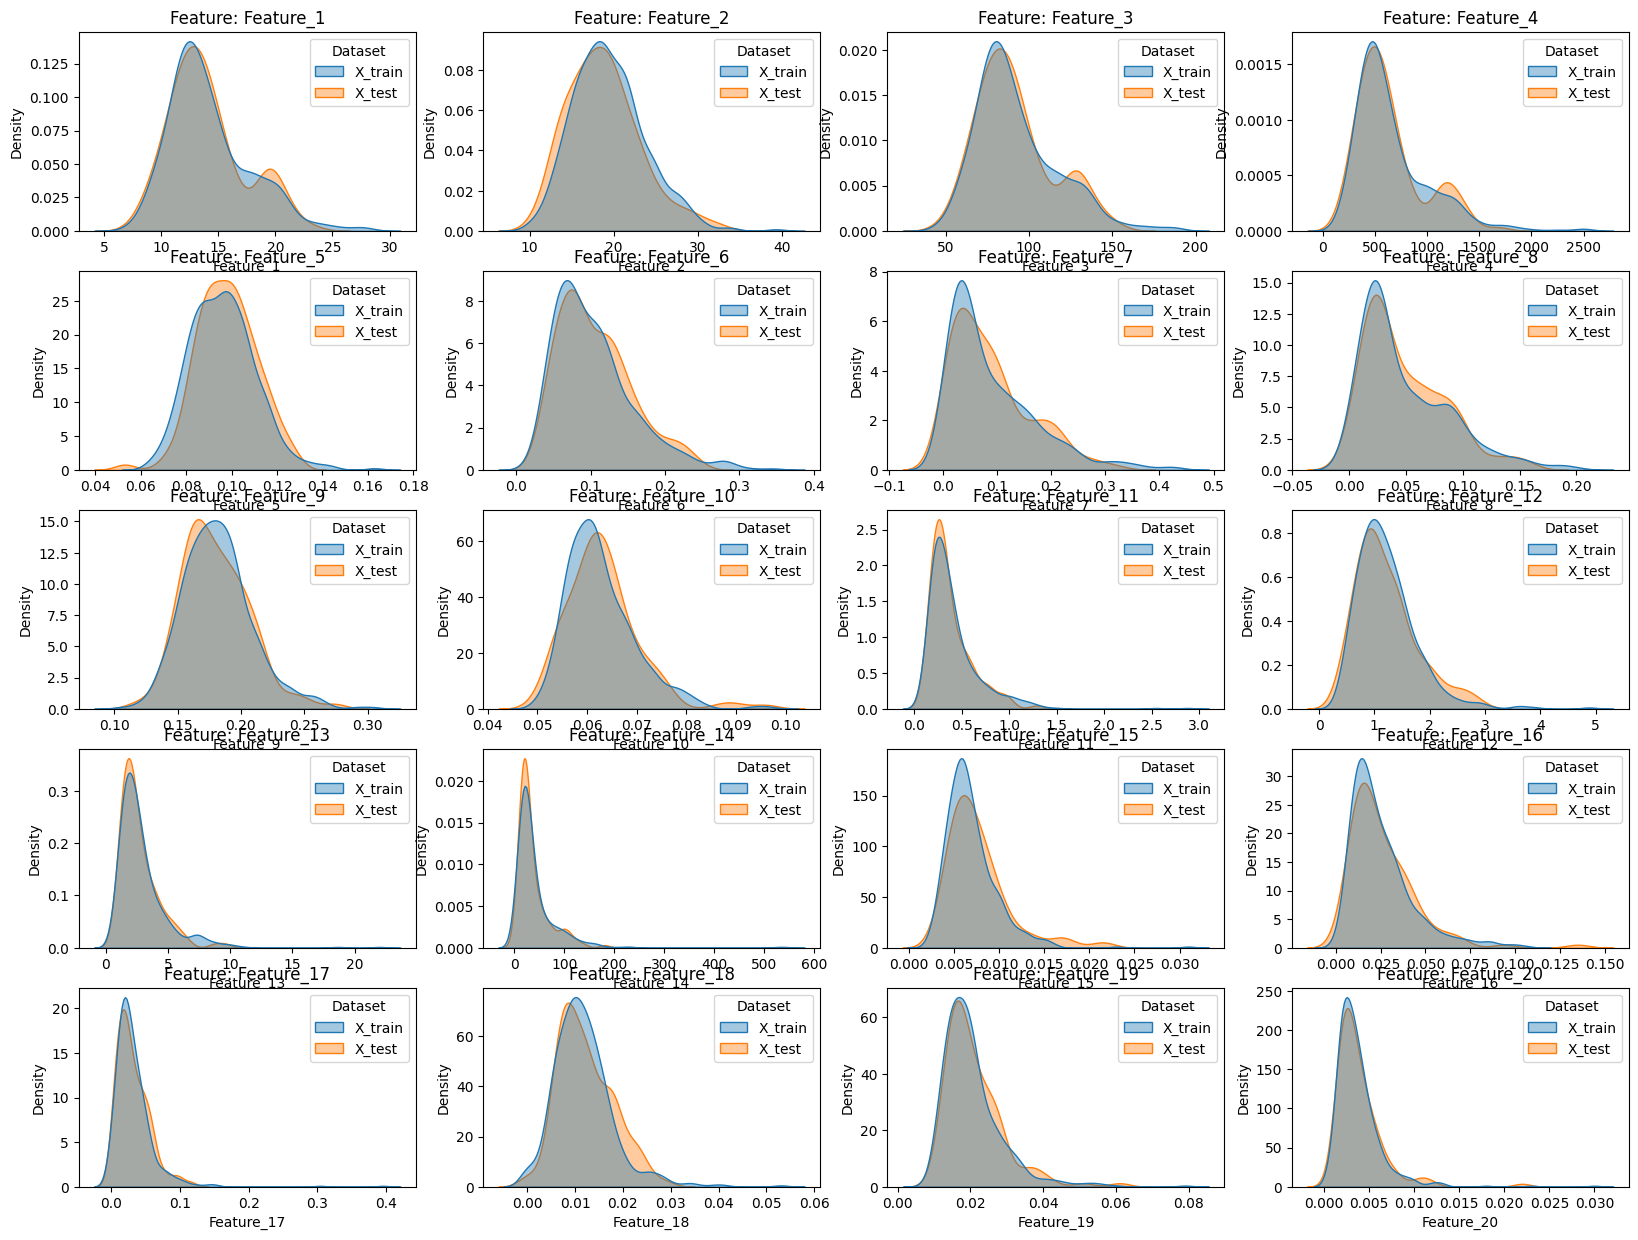

In [9]:
feature_names_train = [f'Feature_{i+1}' for i in range(X_train.shape[1])]

df1 = pd.DataFrame(X_train, columns=feature_names_train)
df1['Label'] = y_train
df1['Dataset'] = 'X_train'

feature_names_test = [f'Feature_{i+1}' for i in range(X_test.shape[1])]

df2 = pd.DataFrame(X_test, columns=feature_names_test)
df2['Label'] = y_test       # <-- Fix here: assign y_test to df2, not df1
df2['Dataset'] = 'X_test'

# Combine both train and test dataframes for plotting
df_all = pd.concat([df1, df2], ignore_index=True)

# Plot distributions of each feature side by side
plt.figure(figsize=(20, 15))
for i, feature in enumerate(feature_names_train):
    plt.subplot(5, 4, i + 1)
    sns.kdeplot(data=df_all, x=feature, hue='Dataset', common_norm=False, fill=True, alpha=0.4, bw_adjust=0.9)
    plt.title(f"Feature: {feature}")
plt.tight_layout()
plt.show()



# Plot label distribution (only for training set or combined if you want)
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df1, order=sorted(df1['Label'].unique()))
plt.title("Label Distribution (Train Set)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

#### Visualizing noise

ValueError: num must be 1 <= num <= 20, not 21

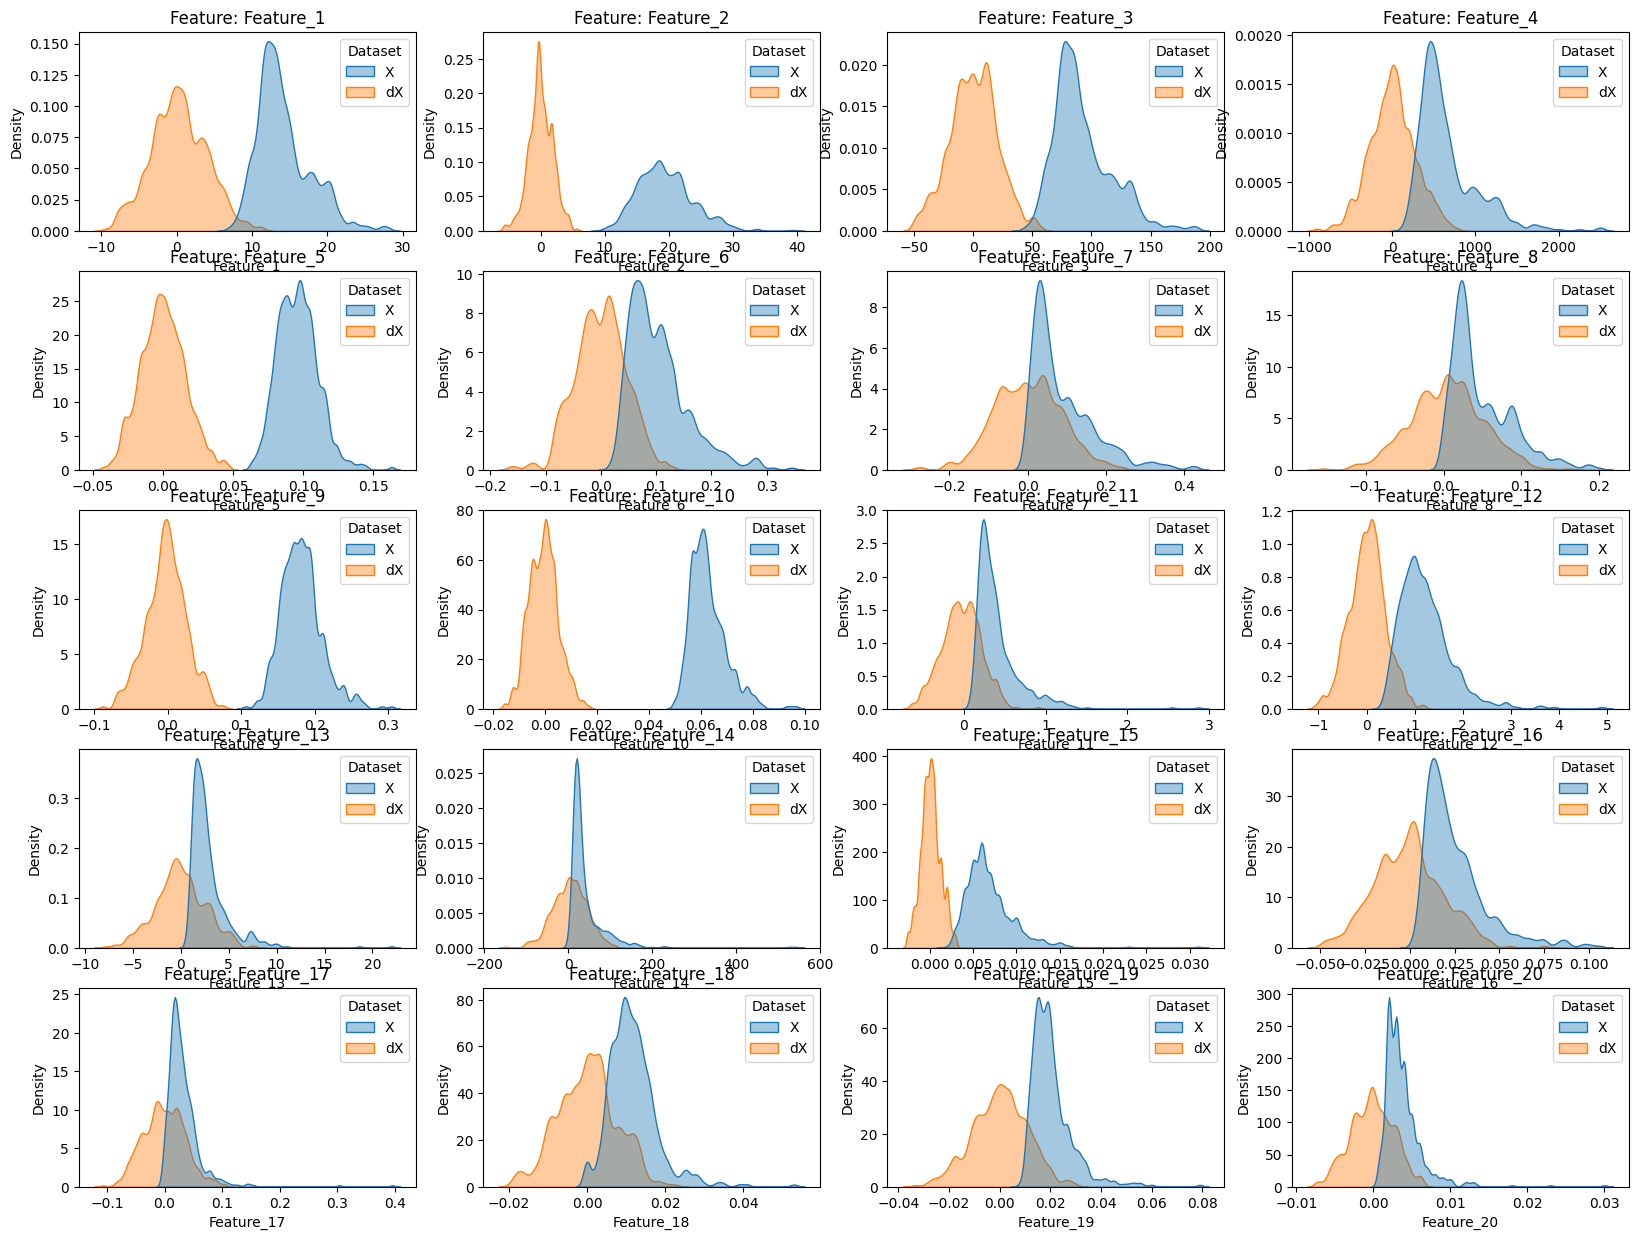

In [10]:
feature_names = [f'Feature_{i+1}' for i in range(X_train.shape[1])]

df1 = pd.DataFrame(X_train, columns=feature_names)
df1['Label'] = y_train
df1['Dataset'] = 'X'

df2 = pd.DataFrame(dX, columns=feature_names)
df2['Dataset'] = 'dX'

# Combine both for easier plotting
df_all = pd.concat([df1, df2], ignore_index=True)

# Plot distributions of each feature side by side
plt.figure(figsize=(20, 15))
for i, feature in enumerate(feature_names):
    plt.subplot(5, 4, i + 1)
    sns.kdeplot(data=df_all, x=feature, hue='Dataset', common_norm=False, fill=True, alpha=0.4, bw_adjust=0.5)
    plt.title(f"Feature: {feature}")
plt.tight_layout()
plt.show()

## SETTING SEEDS

In [11]:
import numpy as np
import random
import tensorflow as tf
import os

def set_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

SEEDS = [27, 272, 2727, 1, 30, 50]


## PDF

In [12]:
import PRF4DF
import probabilistic_deep_forest as pdf
from sklearn.metrics import accuracy_score

n_cascade_estimators = 4
n_classes = len(label_map)
n_features = X_train.shape[1]

accuracies_PDRF = []

for seed in SEEDS:
    set_all_seeds(seed)

    model = pdf.CascadeForestClassifier(
        random_state=seed, n_jobs=-1,
    )
    prf_estimators = []
    for i in range(n_cascade_estimators):
        estimator = PRF4DF.SklearnCompatiblePRF(
            n_classes_=n_classes,
            n_features_=n_features,
            n_estimators=20,
            max_depth=4,
            n_jobs=-1
        )
        prf_estimators.append(estimator)

    model.set_estimator(prf_estimators)
    model.fit(X=X_train_noisy, y=y_train_noisy)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_pred, y_test)
    accuracies_PDRF.append(acc)

mean_acc = np.mean(accuracies_PDRF)
std_acc = np.std(accuracies_PDRF)
print(f"PDRF Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


[2025-06-12 21:24:35.044] Start to fit the model:
[2025-06-12 21:24:35.044] Fitting cascade layer = 0 


KeyboardInterrupt: 

## Other methods for classification

#### Probabilistic Random Forest

In [5]:
import PRF

accuracies_PRF = []

for seed in SEEDS:
    set_all_seeds(seed)
    prf_cls = PRF.prf(n_estimators=200, bootstrap=True)
    prf_cls.fit(X=X_train_noisy, py=py, dX=dX)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_pred, y_test)
    accuracies_PRF.append(acc)

mean_acc = np.mean(accuracies_PRF)
std_acc = np.std(accuracies_PRF)
print(f"PRF Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


KeyboardInterrupt: 

#### Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

accuracies_RF = []

for seed in SEEDS:
    set_all_seeds(seed)
    rf = RandomForestClassifier(n_estimators=200, random_state=seed)
    rf.fit(X_train_noisy, y_train_noisy)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies_RF.append(acc)

mean_acc = np.mean(accuracies_RF)
std_acc = np.std(accuracies_RF)
print(f"Random Forest Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


Random Forest Accuracy: 0.7357 ± 0.0052


#### Deep Forest

In [ ]:
from deepforest import CascadeForestClassifier
from sklearn.metrics import accuracy_score

accuracies_DF = []

for seed in SEEDS:
    set_all_seeds(seed)
    clf = CascadeForestClassifier(n_estimators=2, random_state=seed, n_trees=10)
    clf.fit(X_train_noisy, y_train_noisy)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies_DF.append(acc)

mean_acc = np.mean(accuracies_DF)
std_acc = np.std(accuracies_DF)
print(f"Deep Forest Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


[2025-06-12 21:10:36.578] Start to fit the model:
[2025-06-12 21:10:36.578] Fitting cascade layer = 0 
[2025-06-12 21:10:36.629] layer = 0  | Val Acc = 42.500 % | Elapsed = 0.050 s
[2025-06-12 21:10:36.630] Fitting cascade layer = 1 
[2025-06-12 21:10:36.672] layer = 1  | Val Acc = 50.833 % | Elapsed = 0.042 s
[2025-06-12 21:10:36.672] Fitting cascade layer = 2 
[2025-06-12 21:10:36.711] layer = 2  | Val Acc = 45.833 % | Elapsed = 0.039 s
[2025-06-12 21:10:36.711] Early stopping counter: 1 out of 2
[2025-06-12 21:10:36.712] Fitting cascade layer = 3 
[2025-06-12 21:10:36.748] layer = 3  | Val Acc = 47.500 % | Elapsed = 0.036 s
[2025-06-12 21:10:36.748] Early stopping counter: 2 out of 2
[2025-06-12 21:10:36.748] Handling early stopping
[2025-06-12 21:10:36.748] The optimal number of layers: 2
[2025-06-12 21:10:36.748] Start to evalute the model:
[2025-06-12 21:10:36.749] Evaluating cascade layer = 0 
[2025-06-12 21:10:36.750] Evaluating cascade layer = 1 
[2025-06-12 21:10:36.752] Star

/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/deepforest/forest.py:497: UserWarning: Some inputs do not have OOB predictions. This probably means too few trees were used to compute any reliable oob predictions.
  "Some inputs do not have OOB predictions. "
/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/deepforest/forest.py:504: RuntimeWarning: invalid value encountered in true_divide
  / oob_decision_function.sum(axis=1)[:, np.newaxis]
/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/deepforest/forest.py:497: UserWarning: Some inputs do not have OOB predictions. This probably means too few trees were used to compute any reliable oob predictions.
  "Some inputs do not have OOB predictions. "
/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/deepforest/forest.py:504: RuntimeWarning: invalid value encountered in true_divide
  / oob_decision_function.sum(axis=1)[:, np.newaxis]
/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/d

[2025-06-12 21:10:36.788] layer = 0  | Val Acc = 48.333 % | Elapsed = 0.036 s
[2025-06-12 21:10:36.790] Fitting cascade layer = 1 
[2025-06-12 21:10:36.829] layer = 1  | Val Acc = 43.333 % | Elapsed = 0.039 s
[2025-06-12 21:10:36.829] Early stopping counter: 1 out of 2
[2025-06-12 21:10:36.830] Fitting cascade layer = 2 
[2025-06-12 21:10:36.862] layer = 2  | Val Acc = 49.167 % | Elapsed = 0.032 s
[2025-06-12 21:10:36.863] Fitting cascade layer = 3 
[2025-06-12 21:10:36.892] layer = 3  | Val Acc = 47.500 % | Elapsed = 0.029 s
[2025-06-12 21:10:36.892] Early stopping counter: 1 out of 2
[2025-06-12 21:10:36.893] Fitting cascade layer = 4 
[2025-06-12 21:10:36.924] layer = 4  | Val Acc = 46.667 % | Elapsed = 0.031 s
[2025-06-12 21:10:36.924] Early stopping counter: 2 out of 2
[2025-06-12 21:10:36.924] Handling early stopping
[2025-06-12 21:10:36.924] The optimal number of layers: 3
[2025-06-12 21:10:36.925] Start to evalute the model:
[2025-06-12 21:10:36.925] Evaluating cascade layer = 

/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/deepforest/forest.py:497: UserWarning: Some inputs do not have OOB predictions. This probably means too few trees were used to compute any reliable oob predictions.
  "Some inputs do not have OOB predictions. "
/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/deepforest/forest.py:504: RuntimeWarning: invalid value encountered in true_divide
  / oob_decision_function.sum(axis=1)[:, np.newaxis]
/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/deepforest/forest.py:497: UserWarning: Some inputs do not have OOB predictions. This probably means too few trees were used to compute any reliable oob predictions.
  "Some inputs do not have OOB predictions. "
/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/deepforest/forest.py:504: RuntimeWarning: invalid value encountered in true_divide
  / oob_decision_function.sum(axis=1)[:, np.newaxis]
/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/d

[2025-06-12 21:10:36.998] layer = 1  | Val Acc = 47.500 % | Elapsed = 0.037 s
[2025-06-12 21:10:36.998] Early stopping counter: 1 out of 2
[2025-06-12 21:10:36.999] Fitting cascade layer = 2 
[2025-06-12 21:10:37.038] layer = 2  | Val Acc = 41.667 % | Elapsed = 0.038 s
[2025-06-12 21:10:37.038] Early stopping counter: 2 out of 2
[2025-06-12 21:10:37.038] Handling early stopping
[2025-06-12 21:10:37.038] The optimal number of layers: 1
[2025-06-12 21:10:37.038] Start to evalute the model:
[2025-06-12 21:10:37.038] Evaluating cascade layer = 0 
[2025-06-12 21:10:37.040] Start to fit the model:
[2025-06-12 21:10:37.040] Fitting cascade layer = 0 
[2025-06-12 21:10:37.072] layer = 0  | Val Acc = 49.167 % | Elapsed = 0.032 s
[2025-06-12 21:10:37.073] Fitting cascade layer = 1 
[2025-06-12 21:10:37.102] layer = 1  | Val Acc = 39.167 % | Elapsed = 0.030 s
[2025-06-12 21:10:37.103] Early stopping counter: 1 out of 2
[2025-06-12 21:10:37.103] Fitting cascade layer = 2 
[2025-06-12 21:10:37.133]

/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/deepforest/forest.py:497: UserWarning: Some inputs do not have OOB predictions. This probably means too few trees were used to compute any reliable oob predictions.
  "Some inputs do not have OOB predictions. "
/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/deepforest/forest.py:504: RuntimeWarning: invalid value encountered in true_divide
  / oob_decision_function.sum(axis=1)[:, np.newaxis]
/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/deepforest/forest.py:497: UserWarning: Some inputs do not have OOB predictions. This probably means too few trees were used to compute any reliable oob predictions.
  "Some inputs do not have OOB predictions. "
/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/deepforest/forest.py:504: RuntimeWarning: invalid value encountered in true_divide
  / oob_decision_function.sum(axis=1)[:, np.newaxis]
/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/d

[2025-06-12 21:10:37.202] layer = 1  | Val Acc = 45.000 % | Elapsed = 0.033 s
[2025-06-12 21:10:37.202] Early stopping counter: 1 out of 2
[2025-06-12 21:10:37.204] Fitting cascade layer = 2 
[2025-06-12 21:10:37.238] layer = 2  | Val Acc = 50.000 % | Elapsed = 0.035 s
[2025-06-12 21:10:37.239] Fitting cascade layer = 3 
[2025-06-12 21:10:37.277] layer = 3  | Val Acc = 43.333 % | Elapsed = 0.038 s
[2025-06-12 21:10:37.277] Early stopping counter: 1 out of 2
[2025-06-12 21:10:37.278] Fitting cascade layer = 4 
[2025-06-12 21:10:37.315] layer = 4  | Val Acc = 48.333 % | Elapsed = 0.037 s
[2025-06-12 21:10:37.315] Early stopping counter: 2 out of 2
[2025-06-12 21:10:37.315] Handling early stopping
[2025-06-12 21:10:37.315] The optimal number of layers: 3
[2025-06-12 21:10:37.316] Start to evalute the model:
[2025-06-12 21:10:37.316] Evaluating cascade layer = 0 
[2025-06-12 21:10:37.317] Evaluating cascade layer = 1 
[2025-06-12 21:10:37.317] Evaluating cascade layer = 2 
[2025-06-12 21:1

/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/deepforest/forest.py:497: UserWarning: Some inputs do not have OOB predictions. This probably means too few trees were used to compute any reliable oob predictions.
  "Some inputs do not have OOB predictions. "
/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/deepforest/forest.py:504: RuntimeWarning: invalid value encountered in true_divide
  / oob_decision_function.sum(axis=1)[:, np.newaxis]
/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/deepforest/forest.py:497: UserWarning: Some inputs do not have OOB predictions. This probably means too few trees were used to compute any reliable oob predictions.
  "Some inputs do not have OOB predictions. "
/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/deepforest/forest.py:504: RuntimeWarning: invalid value encountered in true_divide
  / oob_decision_function.sum(axis=1)[:, np.newaxis]
/home/fabyk/PROJECT_PML/PML/venv/lib/python3.7/site-packages/d

#### Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from scikeras.wrappers import KerasClassifier

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # CPU only

accuracies_NN = []

unique_classes = np.unique(y_train)
num_classes = len(unique_classes)
is_binary = num_classes == 2

if not is_binary:
    y_train_cat = to_categorical(np.searchsorted(unique_classes, y_train_noisy))
    y_test_cat = to_categorical(np.searchsorted(unique_classes, y_test))
else:
    y_train_cat = y_train_noisy
    y_test_cat = y_test

def create_model(hidden_units=64, dropout_rate=0.5, optimizer='adam'):
    model = Sequential()
    model.add(Dense(hidden_units, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(dropout_rate))
    if is_binary:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    else:
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

for seed in SEEDS:
    set_all_seeds(seed)
    
    model = KerasClassifier(model=create_model, hidden_units=64, dropout_rate=0.5,
                            optimizer='adam', epochs=30, batch_size=16, verbose=0)
    
    model.fit(X_train_noisy, y_train_cat)

    if is_binary:
        y_pred = model.predict(X_test)
        y_true = y_test
    else:
        y_pred = np.argmax(model.predict_proba(X_test), axis=1)
        y_true = np.searchsorted(unique_classes, y_test)

    acc = accuracy_score(y_true, y_pred)
    accuracies_NN.append(acc)

mean_acc = np.mean(accuracies_NN)
std_acc = np.std(accuracies_NN)
print(f"Neural Network Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


Neural Network Accuracy: 0.6833 ± 0.0500


#### Kernel SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

accuracies_KSVM = []

# Using seed for reproducibility
set_all_seeds(SEEDS[0])

# Model and parameter grid
model = SVC()
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

# Performing GridSearchCV once
grid = GridSearchCV(model, param_grid, cv=3, n_jobs=-1)
grid.fit(X_train_noisy, y_train_noisy)

# Get best model
best_svm = grid.best_estimator_

# Predict and evaluate
y_pred = best_svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)

accuracies_KSVM = [acc] * len(SEEDS)

mean_acc = np.mean(accuracies_KSVM)
std_acc = np.std(accuracies_KSVM)
print(f"Kernel SVM Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


Kernel SVM Accuracy: 0.8333 ± 0.0000


## Results Comparison

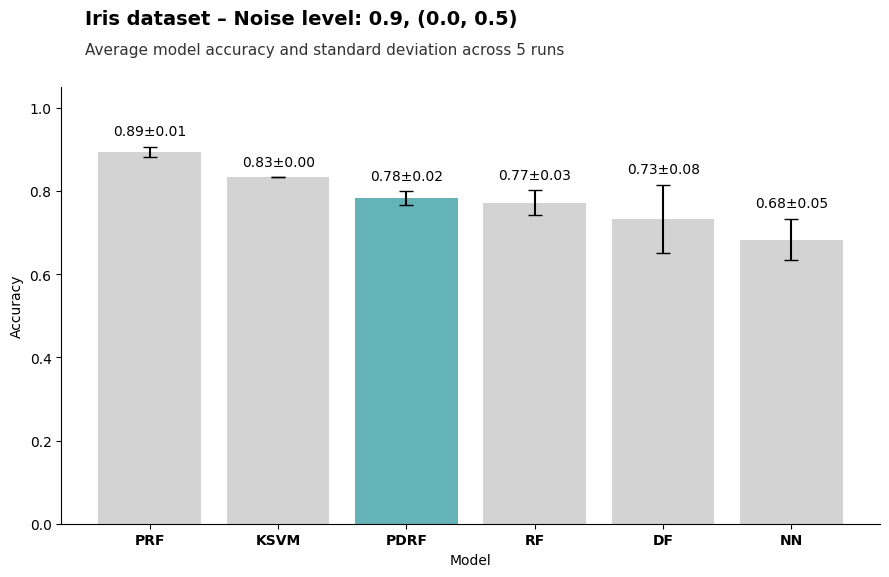

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Building df for comparison
comparison_df = pd.DataFrame({
    "Model": ["PDRF", "PRF", "DF", "RF", "NN", "KSVM"],
    "Mean Accuracy": [
        np.mean(accuracies_PDRF),
        np.mean(accuracies_PRF),
        np.mean(accuracies_DF),
        np.mean(accuracies_RF),
        np.mean(accuracies_NN),
        np.mean(accuracies_KSVM),
    ],
    "Std": [
        np.std(accuracies_PDRF),
        np.std(accuracies_PRF),
        np.std(accuracies_DF),
        np.std(accuracies_RF),
        np.std(accuracies_NN),
        np.std(accuracies_KSVM),
    ]
})


comparison_df = comparison_df.sort_values("Mean Accuracy", ascending=False)

def get_color(model):
    return "#55bfc7" if model == "PDRF" else "lightgray"
colors = comparison_df["Model"].apply(get_color)

# Extracting base name from file path
base_name = os.path.splitext(os.path.basename(file_path))[0]  # e.g., "phoneme"
title_name = base_name.replace('_', ' ').title()              # e.g., "Phoneme"

# Output path
output_dir = "../results/1_low_noise/plots/"
os.makedirs(output_dir, exist_ok=True)
output_filename = os.path.join(output_dir, f"{base_name}_low_noise.png")


# 5. Create the plot
fig, ax = plt.subplots(figsize=(9, 6))

sns.barplot(
    data=comparison_df,
    x="Model",
    y="Mean Accuracy",
    palette=colors,
    errorbar=None,
    ax=ax
)

# Error bars added manually
x_positions = range(len(comparison_df))
means = comparison_df["Mean Accuracy"].values
stds = comparison_df["Std"].values
ax.errorbar(
    x=x_positions,
    y=means,
    yerr=stds,
    fmt='none',
    ecolor='black',
    elinewidth=1.5,
    capsize=5
)

ax.set_ylabel("Accuracy")
ax.set_xlabel("Model")
ax.set_ylim(0, 1.05)
sns.despine()

# Annotation above error bars
for x, (mean, std) in enumerate(zip(means, stds)):
    ax.text(
        x, mean + std + 0.02,
        f'{mean:.2f}±{std:.2f}',
        ha='center', va='bottom',
        fontsize=10, color='black'
    )

ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')

fig.text(
    0.1, 0.93,
    f"{title_name} dataset – Noise level: {noise_scale}, {label_noise_range}",
    ha='left',
    fontsize=14,
    fontweight='bold'
)
fig.text(
    0.1, 0.88,
    "Average model accuracy and standard deviation across 5 runs",
    ha='left',
    fontsize=11, color = "#333333"
)

plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.show()


#### Saving results

In [ ]:
results_df = pd.DataFrame({
    "Model": ["PDRF", "PRF", "DF", "RF", "NN", "KSVM"],
    "Mean Accuracy": [
        np.mean(accuracies_PDRF),
        np.mean(accuracies_PRF),
        np.mean(accuracies_DF),
        np.mean(accuracies_RF),
        np.mean(accuracies_NN),
        np.mean(accuracies_KSVM),
    ],
    "Std": [
        np.std(accuracies_PDRF),
        np.std(accuracies_PRF),
        np.std(accuracies_DF),
        np.std(accuracies_RF),
        np.std(accuracies_NN),
        np.std(accuracies_KSVM),
    ],
    "Seeds": [SEEDS] * 6
})

# results_df.to_csv("../results/1_low_noise/tables/"+f"{base_name}_low_noise.csv", index=False)
# print("Saved to results/1_low_noise/tables/"+f"{base_name}_low_noise.csv")
